## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import arviz as az
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#Import and Read in the data
file = '/Users/zilinyin/desktop/retop2018.csv'
df = pd.read_csv(file)

In [2]:
#Just to have a brief look of the dataset
print(df.shape)
print(df.head())

(100, 17)
                      id                          name       artists  \
0  6DCZcSspjsKoFjzjrWoCd                    God's Plan         Drake   
1  3ee8Jmje8o58CHK66QrVC                          SAD!  XXXTENTACION   
2  0e7ipj03S05BNilyu5bRz    rockstar (feat. 21 Savage)   Post Malone   
3  3swc6WTsr7rl9DqQKQA55  Psycho (feat. Ty Dolla $ign)   Post Malone   
4  2G7V7zsVDxg1yRsu7Ew9R                In My Feelings         Drake   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.754   0.449    7    -9.211     1       0.1090        0.0332   
1         0.740   0.613    8    -4.880     1       0.1450        0.2580   
2         0.587   0.535    5    -6.090     0       0.0898        0.1170   
3         0.739   0.559    8    -8.011     1       0.1170        0.5800   
4         0.835   0.626    1    -5.833     1       0.1250        0.0589   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.000083     0.

In [3]:
#A list containing all the elements of the dataset
elements=['id','name','artists','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','Like']

In [4]:
#Take only the values in digit out and normalize the data
data = df[elements[3:-1]]
data = (data-data.mean())/data.std()
data['Like'] = df[elements[-1]][:]
print(data.shape)
print(data.head())

(100, 14)
   danceability    energy       key  loudness      mode  speechiness  \
0      0.286412 -1.448019  0.454243 -1.987740  0.829437    -0.062845   
1      0.179598 -0.317508  0.726245  0.448723  0.829437     0.281564   
2     -0.987715 -0.855190 -0.089761 -0.231979 -1.193580    -0.246530   
3      0.171969 -0.689749  0.726245 -1.312663  0.829437     0.013690   
4      0.904401 -0.227894 -1.177768 -0.087400  0.829437     0.090225   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0     -0.735478         -0.111585  3.525804 -0.618220 -1.484067    -0.155814   
1      0.281963          0.158855 -0.316151 -0.055509 -1.558592    -0.964829   
2     -0.356201         -0.112872 -0.244506 -1.670876  1.387097     0.323442   
3      1.739330         -0.117749 -0.414662 -0.220442  0.702175     0.405750   
4     -0.619161         -0.113288  2.128730 -0.652176 -1.002716     0.317893   

   time_signature  Like  
0             0.1     1  
1             0.1     1 

## Exploratory Data Analysis

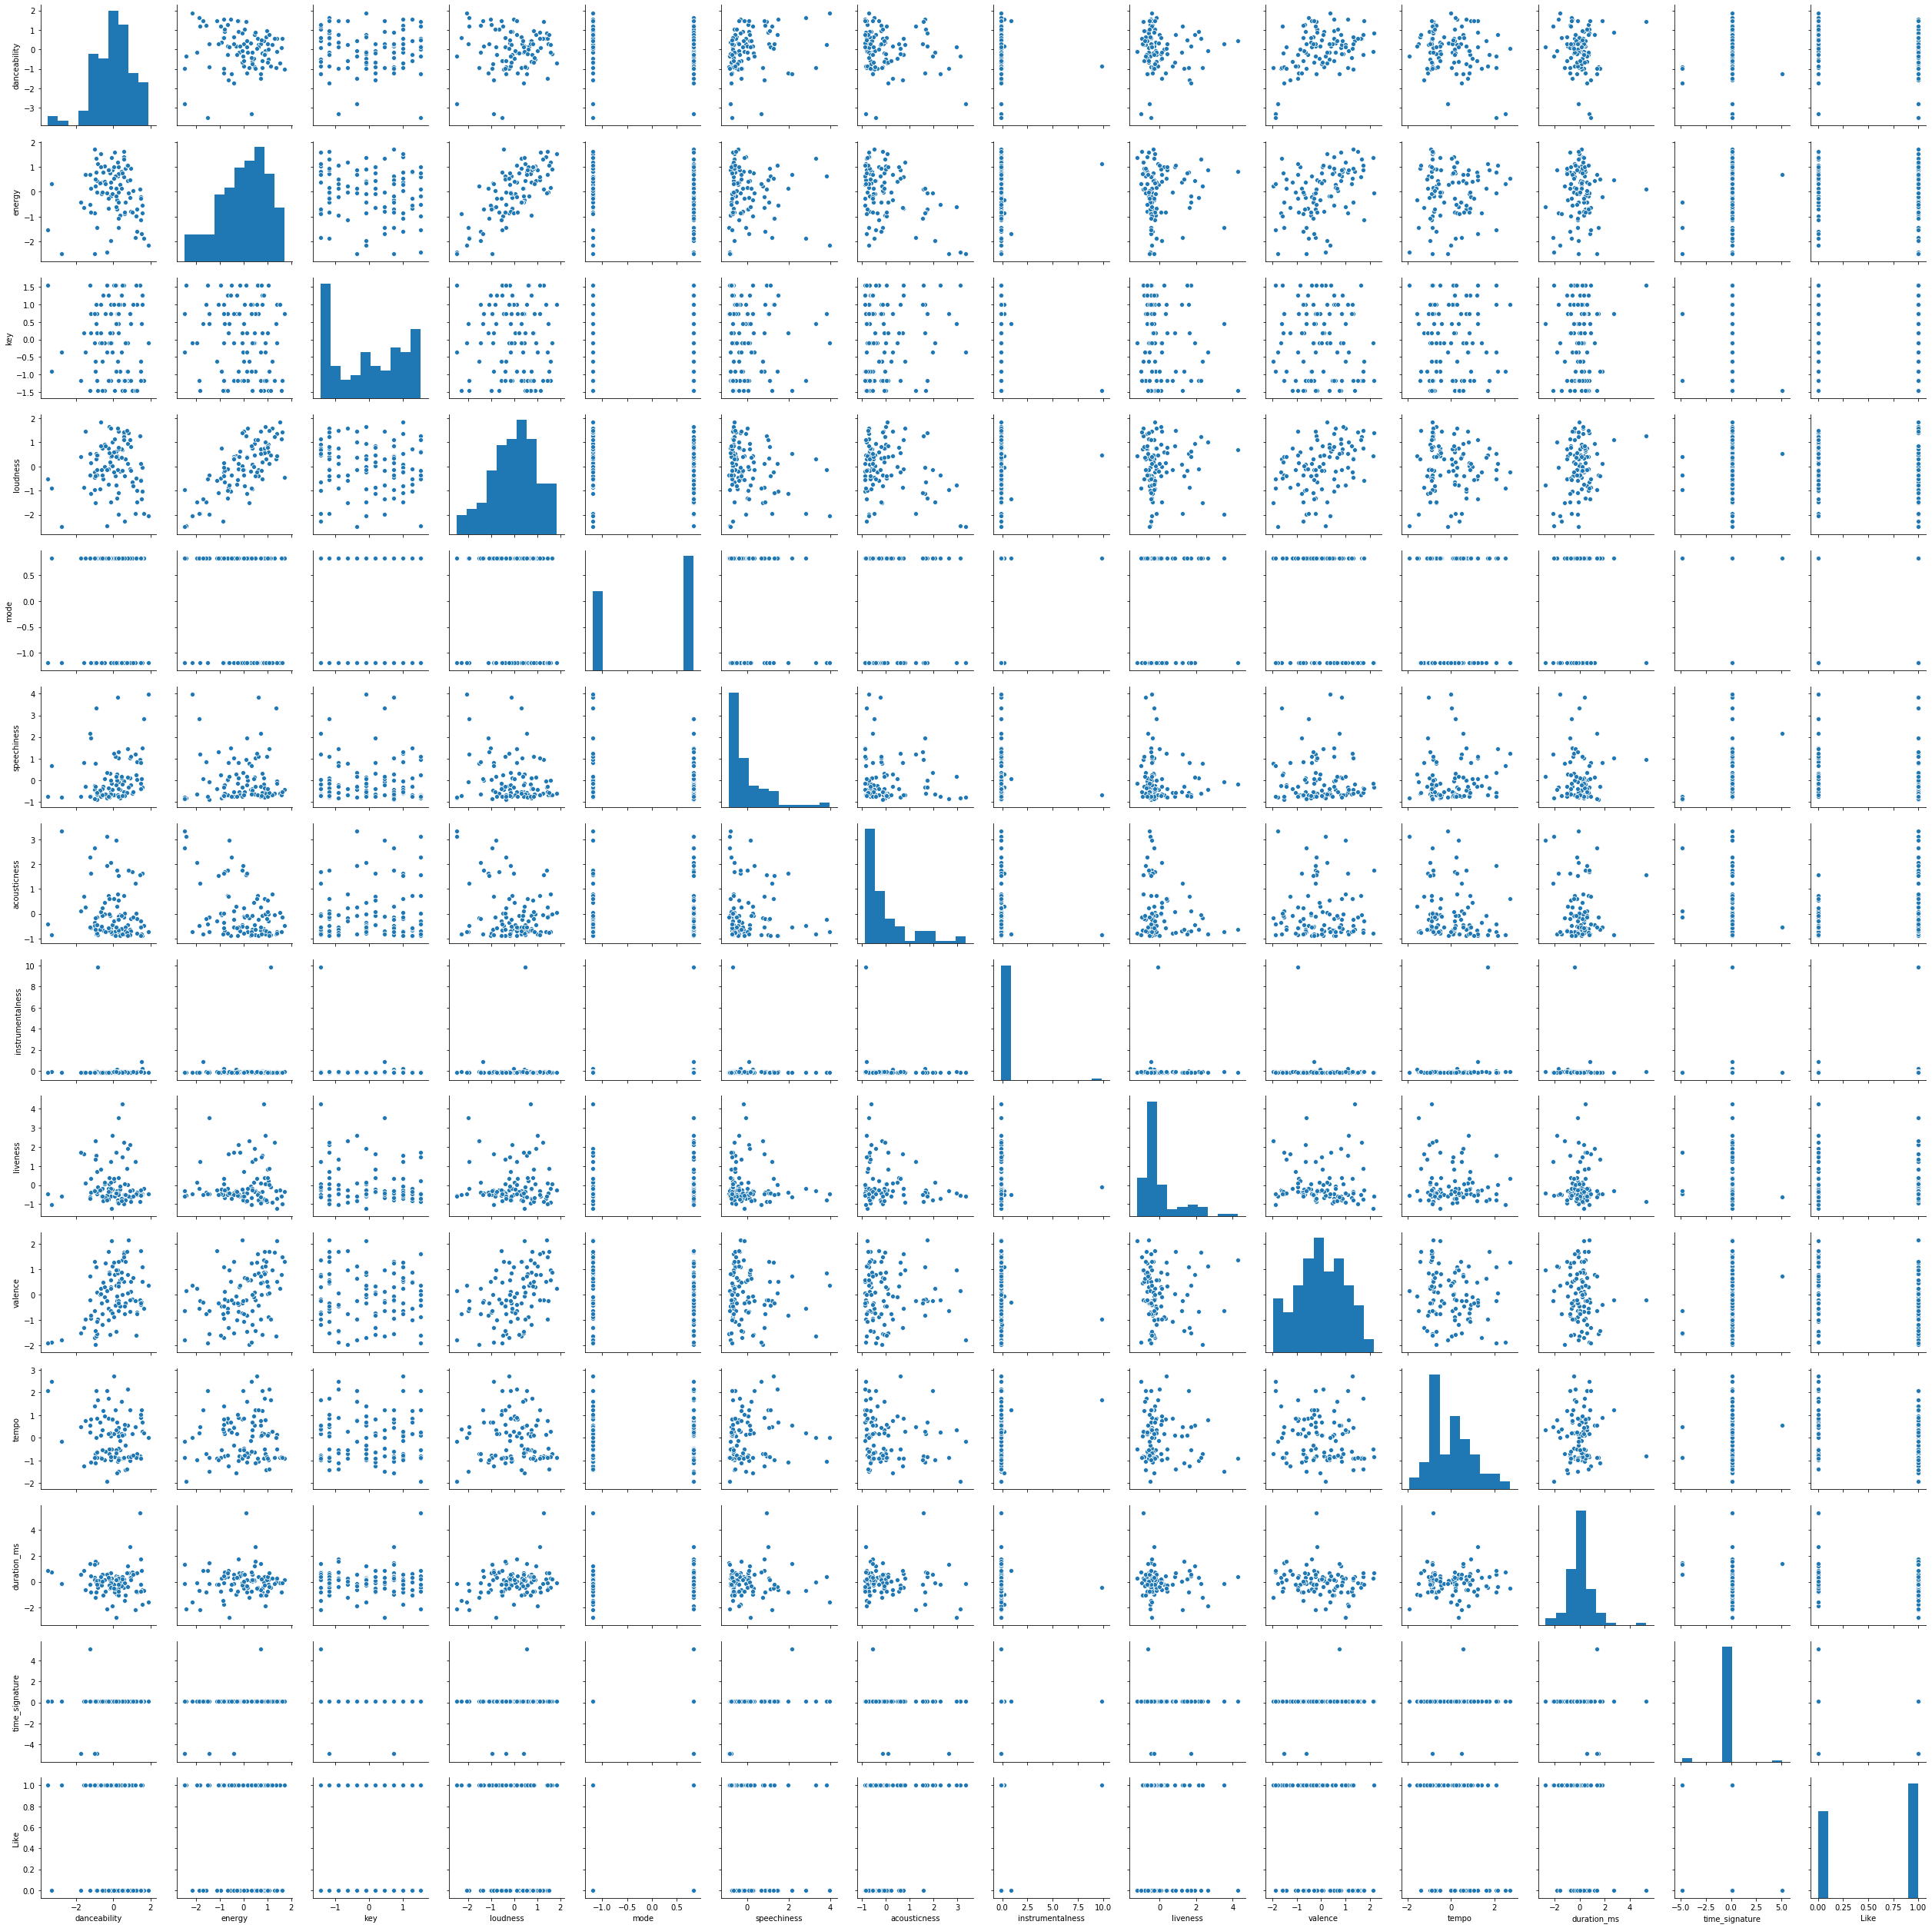

In [5]:
g = sns.pairplot(data)

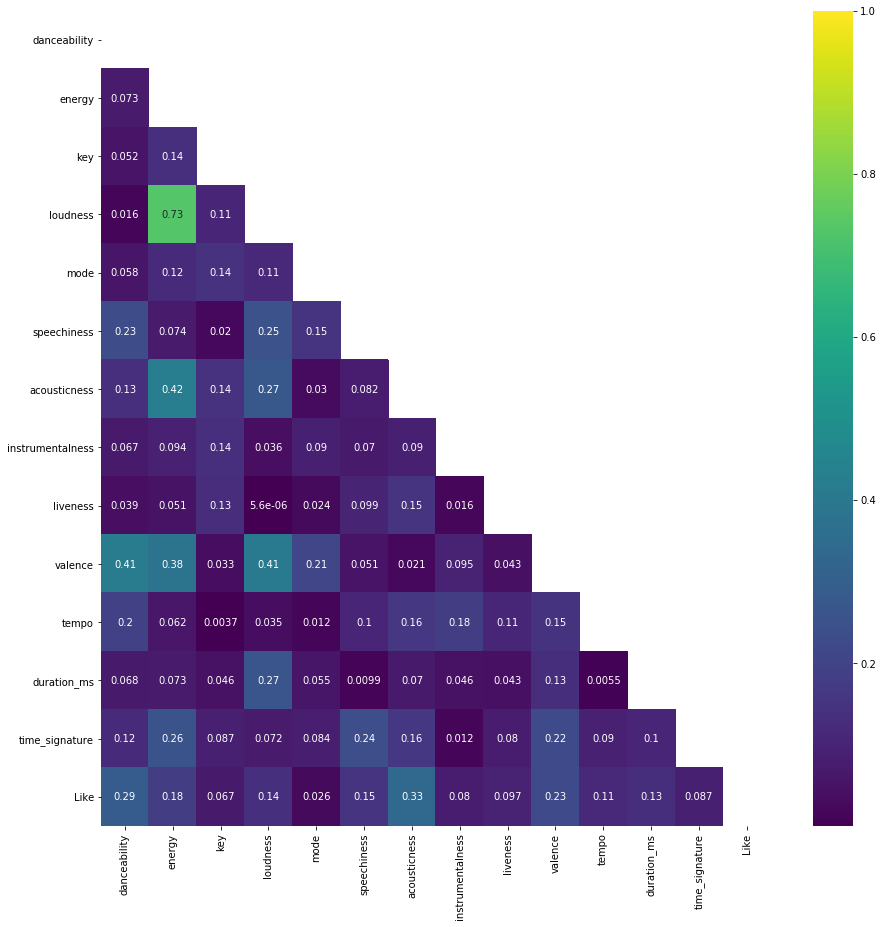

In [6]:
plt.figure(figsize=(15, 15))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
plt.show()

## Logistic Model

In [7]:
#Linear regression model
import pymc3 as pm

predictor = 'danceability'
multiple_model1 = pm.Model()
with multiple_model1:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta')
    yhat = pm.Deterministic('yhat', intercept + pm.math.dot(data[predictor],beta))
    y = pm.Deterministic('y', pm.math.sigmoid(yhat))
    
    bd = pm.Deterministic('bd', -intercept/beta)
    y_1 = pm.Bernoulli('y_1', p=y, observed=data['Like'])
    
    trace1 = pm.sample(init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:00<00:00, 2124.28draws/s]


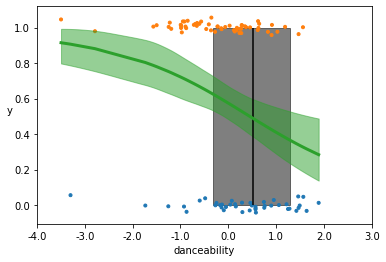

In [8]:
theta = trace1['y'].mean(axis=0)
idx = np.argsort(data[predictor])
plt.plot(data[predictor][idx], theta[idx], color='C2', lw=3)
plt.vlines(trace1['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace1['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(data[predictor], np.random.normal(data['Like'], 0.02), marker='.', color=[f'C{x}' for x in data['Like']])
az.plot_hpd(data[predictor], trace1['y'], color='C2')
plt.xlabel(predictor)
plt.ylabel('y', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + data[predictor].values.mean(), 1));
plt.show()

In [9]:
#Linear regression model
import pymc3 as pm

with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('Like ~ danceability + energy + key + loudness + mode + speechiness + acousticness + instrumentalness + liveness + valence + tempo + duration_ms + time_signature', data, family=pm.glm.families.Binomial())
    trace = pm.sample(init = 'adapt_diag') # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [time_signature, duration_ms, tempo, valence, liveness, instrumentalness, acousticness, speechiness, mode, loudness, key, energy, danceability, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 509.76draws/s]


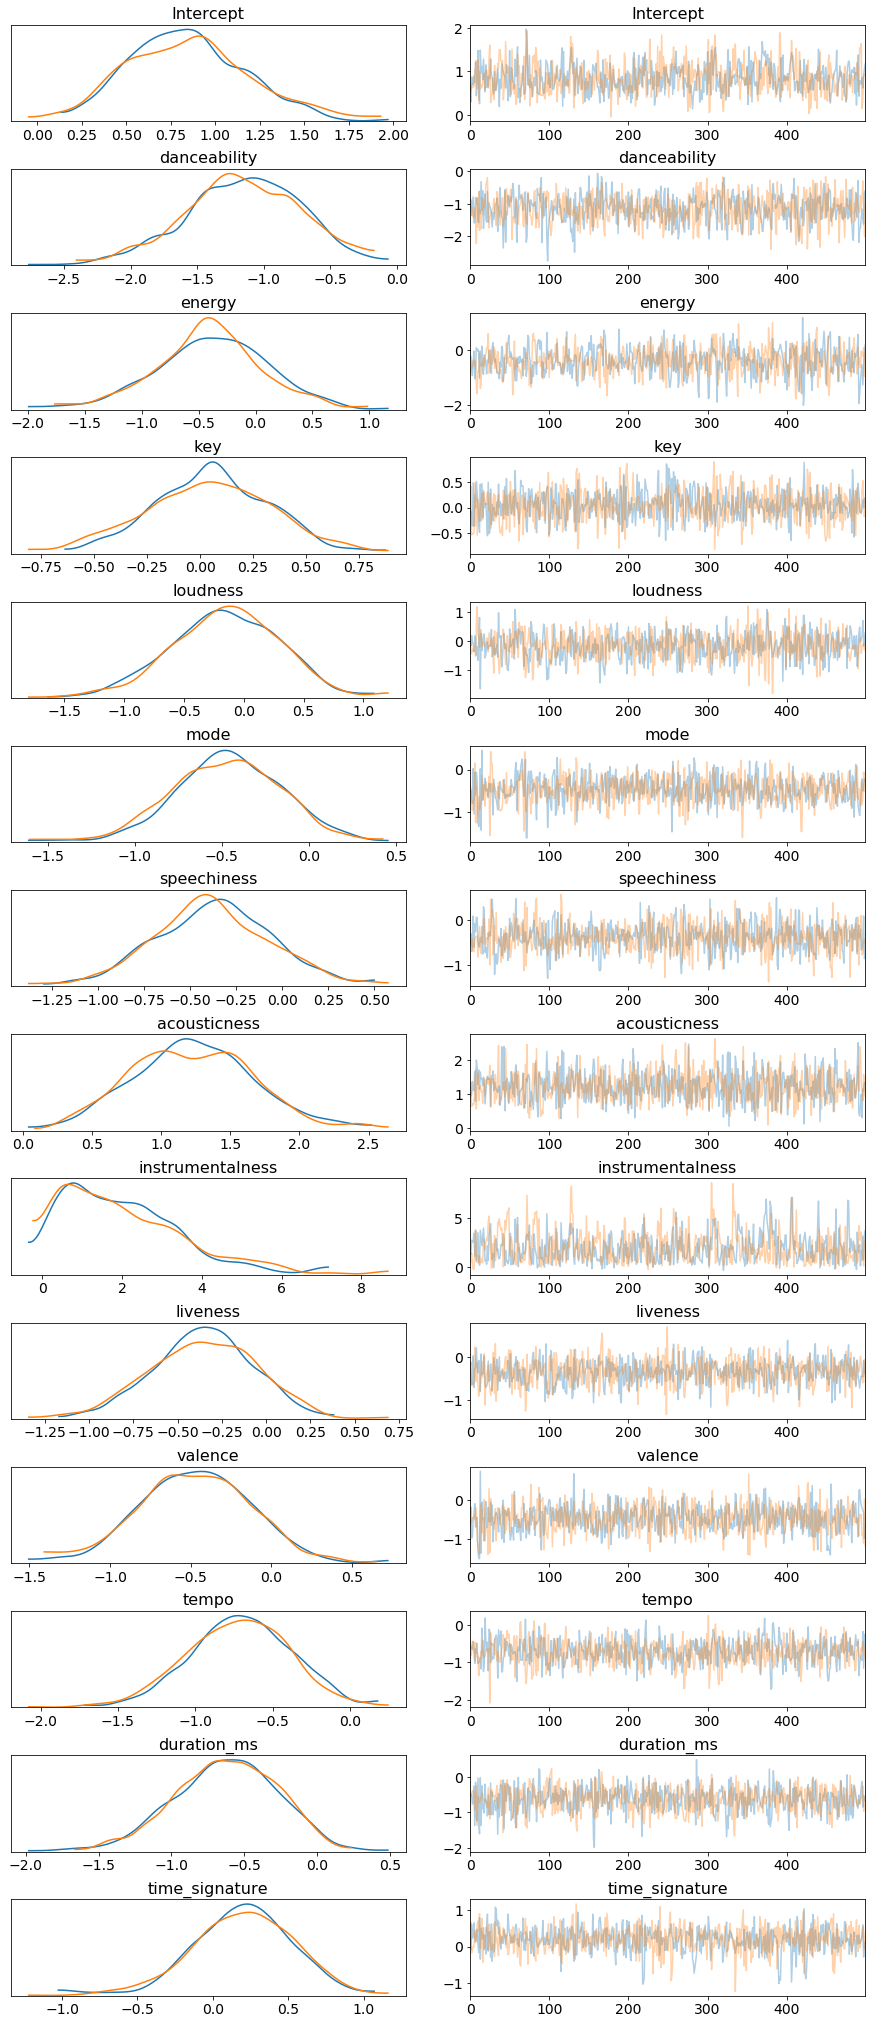

In [10]:
az.plot_trace(trace);

In [11]:
#predictors = ['danceability','acousticness','instrumentalness'
            #,'liveness','valence','tempo','duration_ms']
    
predictors = elements[3:-1]

multiple_model3 = pm.Model()
with multiple_model3:
    intercept = pm.Normal('intercept', sd = 1)
    beta      = pm.Normal('beta',shape=len(predictors))
    #yhat = pm.Deterministic('yhat', intercept + pm.math.dot(data[predictors],beta))
    yhat = intercept + pm.math.dot(data[predictors],beta)
    y = pm.math.sigmoid(yhat)
    
    bd = -intercept/beta
    y_1 = pm.Bernoulli('y_1', p=y, observed=data['Like'])
    
    trace3 = pm.sample(init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1073.84draws/s]


In [12]:
ppc = pm.sample_ppc(trace3, model=multiple_model3, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')
print('Accuracy of the simplest model:', accuracy_score(preds, data['Like']))
print('f1 score of the simplest model:', f1_score(preds, data['Like']))

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 500/500 [00:00<00:00, 1510.89it/s]

Accuracy of the simplest model: 0.74
f1 score of the simplest model: 0.7796610169491526


Confusion matrix
[[28 15]
 [11 46]]


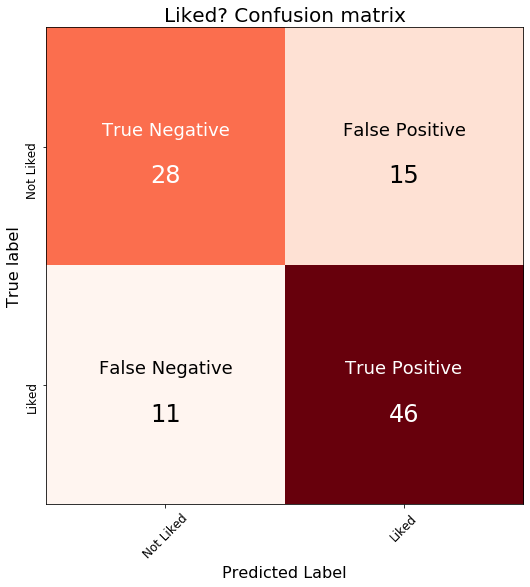

In [13]:
import itertools

def plot_confusion_matrix(cm, classes = ['Not Liked', 'Liked'],
                          title='Liked? Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    plt.figure(figsize=(8, 8))
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)
    
    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
cm = confusion_matrix(data['Like'], preds)
plot_confusion_matrix(cm)

In [14]:
with multiple_model3:
    waic = pm.stats.waic(trace3)
print(waic)

WAIC_r(WAIC=130.37280245350084, WAIC_se=11.801548601068976, p_WAIC=13.908635704240245, var_warn=1)


/Users/zilinyin/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [15]:
print('intercept:')
print(trace3['intercept'].mean())
print('beta:')
for i in range(len(trace3['beta'][0])):
    print(trace3['beta'][:,i].mean())
pm.summary(trace3)['Rhat']

intercept:
0.5704159787149757
beta:
-0.887901439140787
-0.3185104648517073
0.03502435793868257
-0.11869374982139197
-0.37215018339384776
-0.3460896638858537
0.9884028682813318
0.7045182495850145
-0.30043027791874105
-0.4317335292184632
-0.5499583154923295
-0.48654153250619425
0.12873566689907498


intercept    0.999280
beta__0      1.000057
beta__1      1.001024
beta__2      1.000769
beta__3      0.999216
beta__4      0.999345
beta__5      0.999047
beta__6      1.001499
beta__7      0.999074
beta__8      0.999261
beta__9      1.001976
beta__10     0.999130
beta__11     1.000130
beta__12     0.999704
Name: Rhat, dtype: float64

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


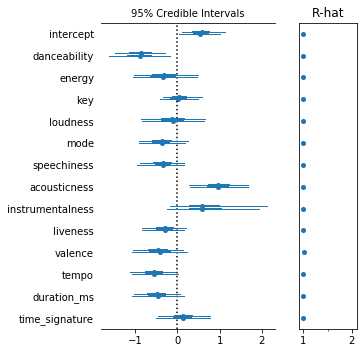

In [16]:
plt.figure(figsize=(5,5))
pm.forestplot(trace3, ylabels = ['intercept'] + predictors);

In [17]:
ppc = pm.sample_posterior_predictive(trace3, samples=2000, model=multiple_model3)

100%|██████████| 2000/2000 [00:01<00:00, 1952.58it/s]


In [18]:
np.asarray(ppc['y_1']).shape

(2000, 100)

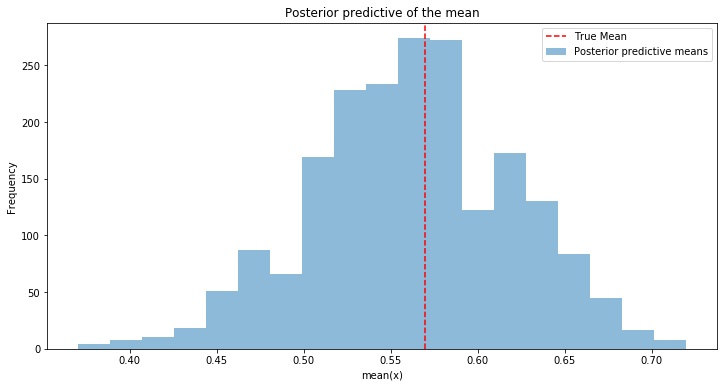

In [19]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([y_1.mean() for y_1 in ppc['y_1']], bins=19, alpha=0.5, label='Posterior predictive means')
ax.axvline(data['Like'].mean(), label='True Mean', color='r', ls='--')
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
ax.legend();

In [20]:
#tempelements = ['danceability','acousticness','instrumentalness'
            #,'liveness','valence','tempo','duration_ms']
tempelements = elements[3:-1]
tempdata = df[tempelements]
print(tempdata.head())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.754   0.449    7    -9.211     1       0.1090        0.0332   
1         0.740   0.613    8    -4.880     1       0.1450        0.2580   
2         0.587   0.535    5    -6.090     0       0.0898        0.1170   
3         0.739   0.559    8    -8.011     1       0.1170        0.5800   
4         0.835   0.626    1    -5.833     1       0.1250        0.0589   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0          0.000083     0.552    0.357   77.169       198973               4  
1          0.003720     0.123    0.473   75.023       166606               4  
2          0.000066     0.131    0.140  159.847       218147               4  
3          0.000000     0.112    0.439  140.124       221440               4  
4          0.000060     0.396    0.350   91.030       217925               4  


In [21]:
#variables = ['danceability','acousticness','instrumentalness'
            #,'liveness','valence','tempo','duration_ms']
variables = elements[3:-1]

dataf = tempdata
#13 elements in total
for thing in variables:
    if variables.index(thing) <= 11:
        for i in range(variables.index(thing)+1, len(variables)):
            dataf[thing+variables[i]] = dataf[thing]*dataf[variables[i]]
print(dataf.head())
print(dataf.shape)

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.754   0.449    7    -9.211     1       0.1090        0.0332   
1         0.740   0.613    8    -4.880     1       0.1450        0.2580   
2         0.587   0.535    5    -6.090     0       0.0898        0.1170   
3         0.739   0.559    8    -8.011     1       0.1170        0.5800   
4         0.835   0.626    1    -5.833     1       0.1250        0.0589   

   instrumentalness  liveness  valence  ...  livenessvalence  livenesstempo  \
0          0.000083     0.552    0.357  ...         0.197064      42.597288   
1          0.003720     0.123    0.473  ...         0.058179       9.227829   
2          0.000066     0.131    0.140  ...         0.018340      20.939957   
3          0.000000     0.112    0.439  ...         0.049168      15.693888   
4          0.000060     0.396    0.350  ...         0.138600      36.047880   

   livenessduration_ms  livenesstime_signature  valencetempo  \
0         

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [22]:
#predictors2 = ['danceability','acousticness','instrumentalness'
            #,'liveness','valence','tempo','duration_ms']
predictors2 = elements[3:-1]
    
for thing in variables:
    if variables.index(thing) <= 11:
        for i in range(variables.index(thing)+1, len(variables)):
            predictors2.append(thing+variables[i])
print(predictors2)

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'danceabilityenergy', 'danceabilitykey', 'danceabilityloudness', 'danceabilitymode', 'danceabilityspeechiness', 'danceabilityacousticness', 'danceabilityinstrumentalness', 'danceabilityliveness', 'danceabilityvalence', 'danceabilitytempo', 'danceabilityduration_ms', 'danceabilitytime_signature', 'energykey', 'energyloudness', 'energymode', 'energyspeechiness', 'energyacousticness', 'energyinstrumentalness', 'energyliveness', 'energyvalence', 'energytempo', 'energyduration_ms', 'energytime_signature', 'keyloudness', 'keymode', 'keyspeechiness', 'keyacousticness', 'keyinstrumentalness', 'keyliveness', 'keyvalence', 'keytempo', 'keyduration_ms', 'keytime_signature', 'loudnessmode', 'loudnessspeechiness', 'loudnessacousticness', 'loudnessinstrumentalness', 'loudnessliveness', 'loudnessvalence', 'loudnesstempo', 'loudnessdu

In [23]:
dataf = (dataf-dataf.mean())/dataf.std()
dataf['Like'] = df[elements[-1]][:]
print(dataf.shape)

(100, 92)


In [24]:
"""
with pm.Model() as logistic_model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('Like ~ danceability + acousticness + instrumentalness + liveness + valence + tempo + duration_ms + danceabilityacousticness + danceabilityinstrumentalness + danceabilityliveness + danceabilityvalence + danceabilitytempo + danceabilityduration_ms + acousticnessinstrumentalness + acousticnessliveness + acousticnessvalence + acousticnesstempo + acousticnessduration_ms + instrumentalnessliveness + instrumentalnessvalence + instrumentalnesstempo + instrumentalnessduration_ms + livenessvalence + livenesstempo + livenessduration_ms + valencetempo + valenceduration_ms + tempoduration_ms', dataf)
    trace = pm.sample(500, init = 'adapt_diag') # draw 3000 posterior samples using NUTS sampling
""" 

"\nwith pm.Model() as logistic_model:\n    # specify glm and pass in data. The resulting linear model, its likelihood and\n    # and all its parameters are automatically added to our model.\n    pm.glm.GLM.from_formula('Like ~ danceability + acousticness + instrumentalness + liveness + valence + tempo + duration_ms + danceabilityacousticness + danceabilityinstrumentalness + danceabilityliveness + danceabilityvalence + danceabilitytempo + danceabilityduration_ms + acousticnessinstrumentalness + acousticnessliveness + acousticnessvalence + acousticnesstempo + acousticnessduration_ms + instrumentalnessliveness + instrumentalnessvalence + instrumentalnesstempo + instrumentalnessduration_ms + livenessvalence + livenesstempo + livenessduration_ms + valencetempo + valenceduration_ms + tempoduration_ms', dataf)\n    trace = pm.sample(500, init = 'adapt_diag') # draw 3000 posterior samples using NUTS sampling\n"

In [25]:
multiple_model2 = pm.Model()
with multiple_model2:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta',shape=len(predictors2), sd = 0.1)
    #yhat = pm.Deterministic('yhat', intercept + pm.math.dot(dataf[predictors2],beta))
    yhat = intercept + pm.math.dot(dataf[predictors2],beta)
    y = pm.math.sigmoid(yhat)
    
    bd = -intercept/beta
    y_1 = pm.Bernoulli('y_1', p=y, observed=dataf['Like'])
    
    trace2 = pm.sample(init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 823.05draws/s] 


In [26]:
ppc = pm.sample_ppc(trace2, model=multiple_model2, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')
print('Accuracy of the simplest model:', accuracy_score(preds, dataf['Like']))
print('f1 score of the simplest model:', f1_score(preds, dataf['Like']))

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 500/500 [00:00<00:00, 1501.79it/s]

Accuracy of the simplest model: 0.73
f1 score of the simplest model: 0.7804878048780488


In [27]:
with multiple_model2:
    waic = pm.stats.waic(trace2)
print(waic)

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


WAIC_r(WAIC=123.9396039663046, WAIC_se=6.088888483489058, p_WAIC=7.1105150509866, var_warn=0)


In [28]:
print('intercept:')
print(trace2['intercept'].mean())
print('beta:')
for i in range(len(trace2['beta'][0])):
    print(trace2['beta'][:,i].mean())
for thing in pm.summary(trace2)['Rhat']:
    print(thing)

intercept:
0.35309366887505955
beta:
-0.061380978914672875
-0.012554062208880203
0.01463960919254732
-0.015912423652015763
-0.014282358707707377
-0.022139239725568513
0.05295143528238421
0.022998000806923904
-0.010442395663750608
-0.03297303007987635
-0.024574301701516994
-0.03353642418148713
0.006999072565074726
-0.0543007699741703
-0.02578465664937329
0.018001814901634206
-0.019098138125898216
-0.040202566809684114
0.04880969750920947
0.01730413389602664
-0.02469396319129418
-0.048725608265672266
-0.05236184799540811
-0.06132739404224626
-0.061227251302637
0.01672705903687516
-0.017663258240871473
-0.010089729888597212
-0.0070384214027898314
0.04444707147529093
0.019744970991363676
-0.035175446848346836
-0.04111612872686962
-0.030448994242374326
-0.03511926851650472
-0.014805105128597878
-0.011091688558827492
0.0015640510420877219
0.00758362591444647
0.017295337555194273
-0.019788219157326273
-0.01645067653401495
-0.002970921613116748
0.00897617820071404
-0.005342601802879066
0.01032

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


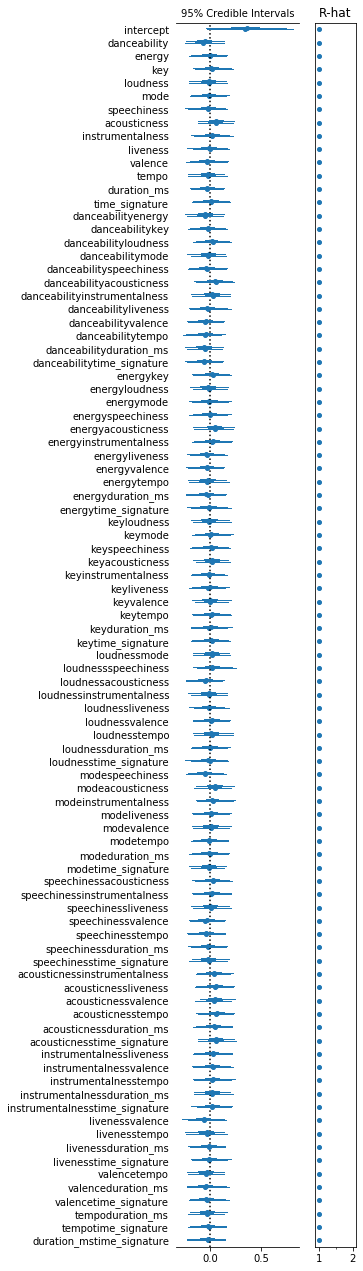

In [29]:
plt.figure(figsize=(5,20))
pm.forestplot(trace2, ylabels = ['intercept'] + predictors2);

In [30]:
ppc = pm.sample_posterior_predictive(trace2, samples=2000, model=multiple_model2)

100%|██████████| 2000/2000 [00:01<00:00, 1933.03it/s]


In [31]:
np.asarray(ppc['y_1']).shape

(2000, 100)

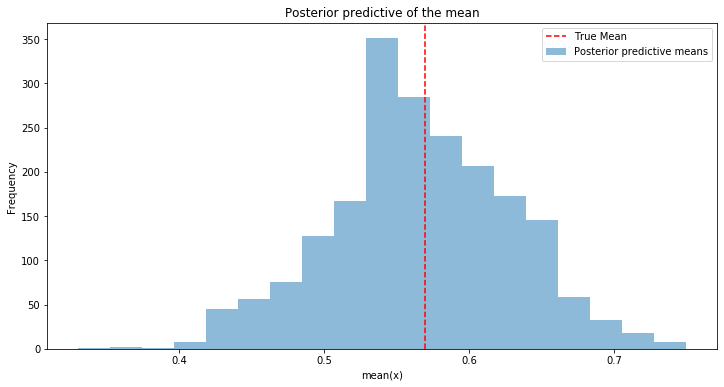

In [32]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([y_1.mean() for y_1 in ppc['y_1']], bins=19, alpha=0.5, label='Posterior predictive means')
ax.axvline(data['Like'].mean(), label='True Mean', color='r', ls='--')
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
ax.legend();

## Ensemble Random Forest

In [33]:
#Data preprocessing for machine learning prediction model
#X = df[elements[3:-1]][:]
#X = (X-X.mean())/X.std()
Xvars = elements[3:-1]
X = df[Xvars]
X = (X-X.mean())/X.std()
Y = df[elements[-1]]
print(Y.shape)
print(X.shape)

(100,)
(100, 13)


In [34]:
import sklearn.tree
import sklearn.model_selection
import sklearn.ensemble
from sklearn.metrics import make_scorer, accuracy_score

#Split into training and validation
(Xt,Xv,yt,yv) = sklearn.model_selection.train_test_split(X,Y,train_size=0.7,random_state=1)
#Decision tree
clf = sklearn.ensemble.RandomForestClassifier(n_estimators = 82, random_state = 1)
#Fit the tree
clf = clf.fit(Xt,yt)

In [35]:
predictions = clf.predict(Xv)
print(accuracy_score(yv, predictions))

0.7666666666666667


In [36]:
#Define the statistical method we want to use
clf = sklearn.ensemble.RandomForestClassifier(n_estimators = 82, oob_score=True,random_state=1)
#Fit the bagging classifier
clf.fit(X,Y)
#Print out of the feature importance per variable
temp = clf.feature_importances_
tmp = []
for thing in temp:
    tmp.append(thing*100)
#Print out of bag estimate of accuracy
print(clf.oob_score_)

0.65


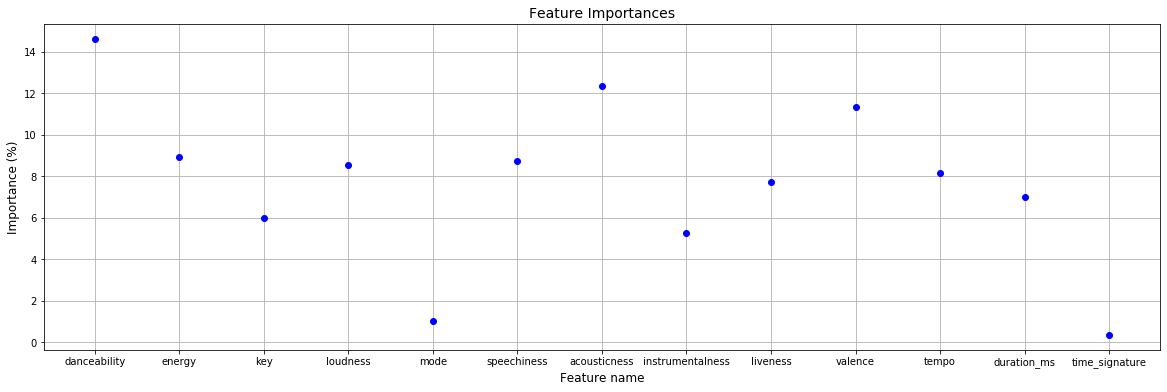

In [37]:
plt.figure(figsize=(20, 6))
plt.plot(Xvars, tmp, 'bo')
plt.grid('on')
plt.xlabel('Feature name', fontsize = 12)
plt.ylabel('Importance (%)', fontsize = 12)
plt.title('Feature Importances', fontsize = 14)
plt.show()

In [38]:
#Find out the optimal number of decision trees
bag_scores = []
for n in range(1, 101):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n, oob_score=True,random_state=1)
    clf.fit(X,Y)
    bag_scores.append(clf.oob_score_)

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

The optimal number of trees is: 82


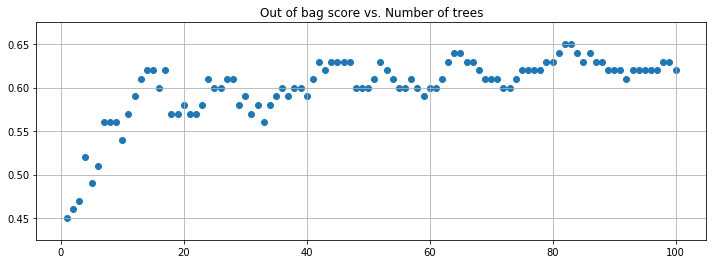

In [39]:
#Make a corresponding plot
x_axis = []
for n in range(1, 101):
    x_axis.append(n)
plt.figure(figsize=(12,4))
plt.scatter(x_axis[:], bag_scores[:])
print('The optimal number of trees is:', bag_scores.index(np.max(bag_scores))+1)
plt.grid('on')
plt.title('Out of bag score vs. Number of trees')
plt.show()

In [40]:
predictions = list(predictions)
temp = []
for thing in yv[:]:
    temp.append(thing)

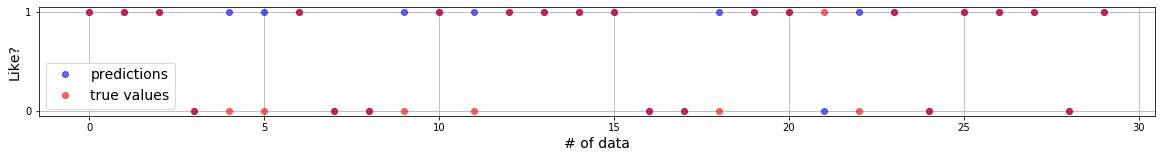

In [41]:
#Plot to compare the difference between the predicitons and the true values
plt.figure(figsize=(20,2))
plt.plot(predictions, 'bo', alpha = 0.6)
plt.plot(temp, 'ro', alpha = 0.6)
plt.legend(['predictions', 'true values'], fontsize = 14)
plt.grid('on')
plt.xlabel('# of data',fontsize=14)
plt.ylabel('Like?',fontsize=14)
plt.yticks([0,1])
plt.show()

Confusion matrix
[[ 7  6]
 [ 1 16]]


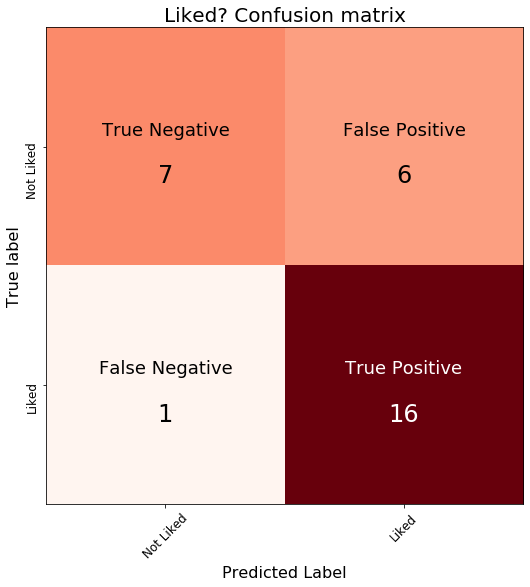

In [42]:
cm = confusion_matrix(temp, predictions)
plot_confusion_matrix(cm)

## Hold Out Data

In [43]:
# Import and read in the hold out data

file = '/Users/zilinyin/desktop/top2019.csv'
hdf = pd.read_csv(file)

In [44]:
#Just to have a brief look of the dataset
print(hdf.shape)
print(hdf.head())

(50, 15)
   Unnamed: 0                       Track.Name    Artist.Name           Genre  \
0           1                         Senorita   Shawn Mendes    canadian pop   
1           2                            China       Anuel AA  reggaeton flow   
2           3    boyfriend (with Social House)  Ariana Grande       dance pop   
3           4  Beautiful People (feat. Khalid)     Ed Sheeran             pop   
4           5      Goodbyes (Feat. Young Thug)    Post Malone         dfw rap   

   Beats.Per.Minute  Energy  Danceability  Loudness..dB..  Liveness  Valence.  \
0               117      55            76              -6         8        75   
1               105      81            79              -4         8        61   
2               190      80            40              -4        16        70   
3                93      65            64              -8         8        55   
4               150      65            58              -4        11        18   

   Length.  Acous

In [45]:
keyelements = ['Energy', 'Danceability', 'Loudness..dB..', 'Liveness', 'Valence.', 'Acousticness..', 'Speechiness.']

hdatatest = hdf[keyelements]
Xtest = hdatatest = (hdatatest - hdatatest.mean())/hdatatest.std()
print(hdatatest.head())
Ytest = hdf['Like']

     Energy  Danceability  Loudness..dB..  Liveness  Valence.  Acousticness..  \
0 -0.636597      0.387263       -0.165334 -0.599012  0.913323       -0.956013   
1  1.190283      0.638732        0.807217 -0.599012  0.286533       -0.745438   
2  1.120018     -2.630370        0.807217  0.120522  0.689469       -0.534862   
3  0.066049     -0.618615       -1.137884 -0.599012  0.017908       -0.534862   
4  0.066049     -1.121554        0.807217 -0.329187 -1.638609        1.202387   

   Speechiness.  
0     -0.849341  
1     -0.311783  
2      3.003155  
3      0.584146  
4     -0.490969  


In [46]:
hpredictors = ['energy', 'danceability', 'loudness', 'liveness', 'valence', 'acousticness', 'speechiness']

hdatatrain = df[hpredictors]
Xtrain = hdatatrain = (hdatatrain - hdatatrain.mean())/hdatatrain.std()
Ytrain = df[elements[-1]]
#hdatatrain['Like'] = df[elements[-1]][:]
print(hdatatrain.head())

     energy  danceability  loudness  liveness   valence  acousticness  \
0 -1.448019      0.286412 -1.987740  3.525804 -0.618220     -0.735478   
1 -0.317508      0.179598  0.448723 -0.316151 -0.055509      0.281963   
2 -0.855190     -0.987715 -0.231979 -0.244506 -1.670876     -0.356201   
3 -0.689749      0.171969 -1.312663 -0.414662 -0.220442      1.739330   
4 -0.227894      0.904401 -0.087400  2.128730 -0.652176     -0.619161   

   speechiness  
0    -0.062845  
1     0.281564  
2    -0.246530  
3     0.013690  
4     0.090225  


In [47]:
#Define the statistical method we want to use
clf = sklearn.ensemble.RandomForestClassifier(n_estimators = 64, oob_score=True,random_state=1)
#Fit the bagging classifier
clf.fit(Xtrain,Ytrain)
#Print out of bag estimate of accuracy
print(clf.oob_score_)

0.68


In [48]:
#Find out the optimal number of decision trees
bag_scores = []
for n in range(1, 101):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n, oob_score=True,random_state=1)
    clf.fit(Xtrain,Ytrain)
    bag_scores.append(clf.oob_score_)

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zilinyin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob e

The optimal number of trees is: 64


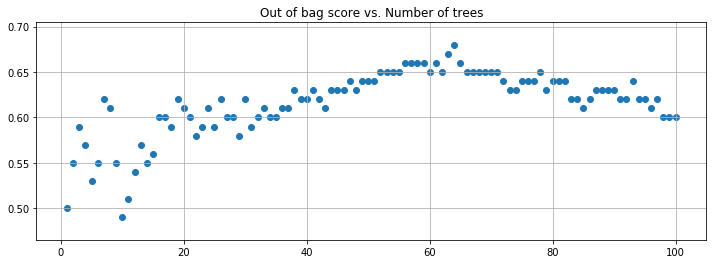

In [49]:
#Make a corresponding plot
x_axis = []
for n in range(1, 101):
    x_axis.append(n)
plt.figure(figsize=(12,4))
plt.scatter(x_axis[:], bag_scores[:])
print('The optimal number of trees is:', bag_scores.index(np.max(bag_scores))+1)
plt.grid('on')
plt.title('Out of bag score vs. Number of trees')
plt.show()

In [50]:
#Decision tree
clf = sklearn.ensemble.RandomForestClassifier(n_estimators = 64, random_state = 1)
#Fit the tree
clf = clf.fit(Xtrain,Ytrain)
#Print out of the feature importance per variable
temp = clf.feature_importances_
tmp = []
for thing in temp:
    tmp.append(thing*100)

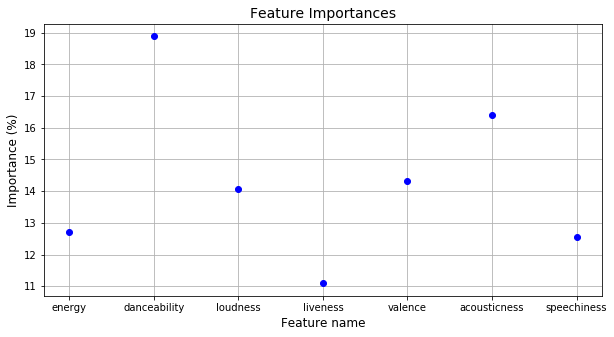

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(hpredictors, tmp, 'bo')
plt.grid('on')
plt.xlabel('Feature name', fontsize = 12)
plt.ylabel('Importance (%)', fontsize = 12)
plt.title('Feature Importances', fontsize = 14)
plt.show()

In [52]:
predictions = clf.predict(Xtest)
print(accuracy_score(Ytest, predictions))

0.74


In [53]:
predictions = list(predictions)
temp = []
for thing in Ytest[:]:
    temp.append(thing)

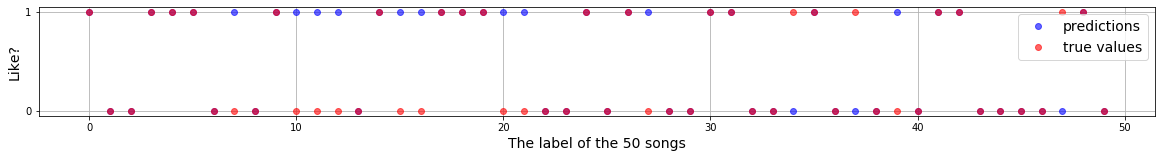

In [54]:
#Plot to compare the difference between the predicitons and the true values
plt.figure(figsize=(20,2))
plt.plot(predictions, 'bo', alpha = 0.6)
plt.plot(temp, 'ro', alpha = 0.6)
plt.legend(['predictions', 'true values'], fontsize = 14)
plt.grid('on')
plt.xlabel('The label of the 50 songs',fontsize=14)
plt.ylabel('Like?',fontsize=14)
plt.yticks([0,1])
plt.show()

Confusion matrix
[[20 10]
 [ 3 17]]


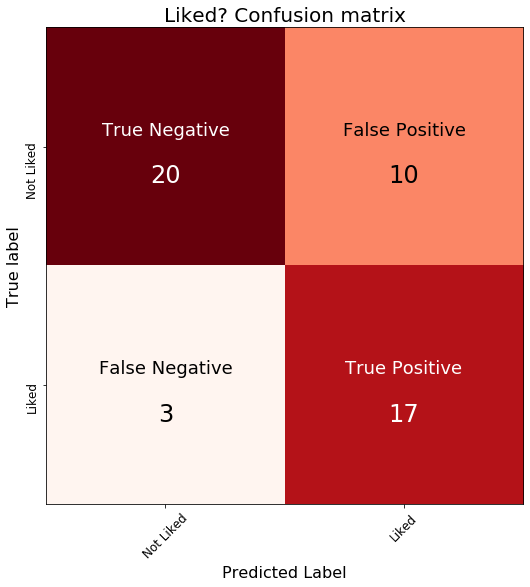

In [55]:
cm = confusion_matrix(temp, predictions)
plot_confusion_matrix(cm)

In [56]:
print(trace2['beta'].shape)
print(trace2['intercept'].shape)

(1000, 91)
(1000,)


In [57]:
multiple_model4 = pm.Model()
with multiple_model4:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta',shape=len(hpredictors), sd = 1)
    #yhat = pm.Deterministic('yhat', intercept + pm.math.dot(dataf[predictors2],beta))
    yhat = intercept + pm.math.dot(data[hpredictors],beta)
    y = pm.math.sigmoid(yhat)
    
    bd = -intercept/beta
    y_1 = pm.Bernoulli('y_1', p=y, observed=data['Like'])
    
    trace4 = pm.sample(init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1173.34draws/s]


In [58]:
print(trace4['beta'].shape)
print(trace4['intercept'].shape)

(1000, 7)
(1000,)


In [59]:
betaf = []
for i in range(7):
    betaf.append(np.mean(trace4['beta'][:,i]))
interceptf = np.mean(trace4['intercept'])

In [60]:
print(hdatatest.head())
print(hdatatest.shape)
print(keyelements)
print(hpredictors)
betahaha = []
for i, j in enumerate(keyelements):
    temp = []
    for thing in hdatatest[j]:
        temp.append(betaf[i]*thing)
    betahaha.append(temp)
betahaha = np.array(betahaha)

     Energy  Danceability  Loudness..dB..  Liveness  Valence.  Acousticness..  \
0 -0.636597      0.387263       -0.165334 -0.599012  0.913323       -0.956013   
1  1.190283      0.638732        0.807217 -0.599012  0.286533       -0.745438   
2  1.120018     -2.630370        0.807217  0.120522  0.689469       -0.534862   
3  0.066049     -0.618615       -1.137884 -0.599012  0.017908       -0.534862   
4  0.066049     -1.121554        0.807217 -0.329187 -1.638609        1.202387   

   Speechiness.  
0     -0.849341  
1     -0.311783  
2      3.003155  
3      0.584146  
4     -0.490969  
(50, 7)
['Energy', 'Danceability', 'Loudness..dB..', 'Liveness', 'Valence.', 'Acousticness..', 'Speechiness.']
['energy', 'danceability', 'loudness', 'liveness', 'valence', 'acousticness', 'speechiness']


In [61]:
import math

betasum = []

for i in range(len(betahaha[0])):
    betasum.append(np.sum(betahaha[:, i]))

result = []
for thing in betasum:
    result.append(1/(1+math.e**-(thing + interceptf)))

In [62]:
resultf = []
for thing in result:
    if thing <= 0.5:
        resultf.append(0)
    if thing > 0.5:
        resultf.append(1)

In [63]:
print(accuracy_score(resultf, Ytest))

0.58


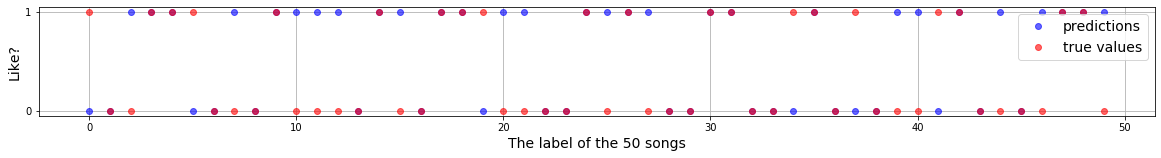

In [64]:
#Plot to compare the difference between the predicitons and the true values
plt.figure(figsize=(20,2))
plt.plot(resultf, 'bo', alpha = 0.6)
plt.plot(Ytest, 'ro', alpha = 0.6)
plt.legend(['predictions', 'true values'], fontsize = 14)
plt.grid('on')
plt.xlabel('The label of the 50 songs',fontsize=14)
plt.ylabel('Like?',fontsize=14)
plt.yticks([0,1])
plt.show()

Confusion matrix
[[15 15]
 [ 6 14]]


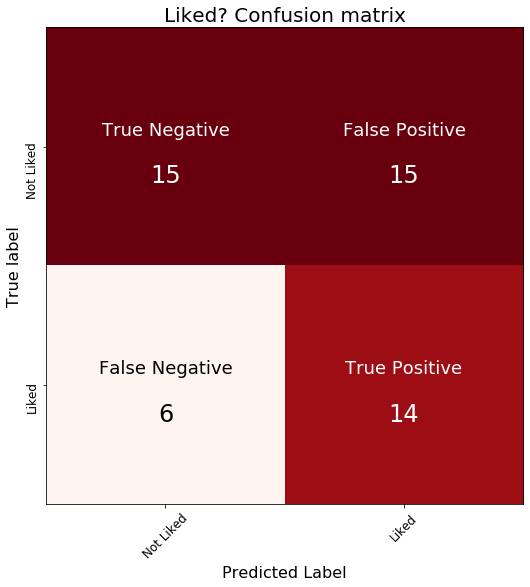

In [65]:
cm = confusion_matrix(Ytest, resultf)
plot_confusion_matrix(cm)

In [66]:
variables = hpredictors

dataf = df[hpredictors]
#13 elements in total
for thing in variables:
    if variables.index(thing) <= 5:
        for i in range(variables.index(thing)+1, len(variables)):
            dataf[thing+variables[i]] = dataf[thing]*dataf[variables[i]]
print(dataf.head())
print(dataf.shape)

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


   energy  danceability  loudness  liveness  valence  acousticness  \
0   0.449         0.754    -9.211     0.552    0.357        0.0332   
1   0.613         0.740    -4.880     0.123    0.473        0.2580   
2   0.535         0.587    -6.090     0.131    0.140        0.1170   
3   0.559         0.739    -8.011     0.112    0.439        0.5800   
4   0.626         0.835    -5.833     0.396    0.350        0.0589   

   speechiness  energydanceability  energyloudness  energyliveness  ...  \
0       0.1090            0.338546       -4.135739        0.247848  ...   
1       0.1450            0.453620       -2.991440        0.075399  ...   
2       0.0898            0.314045       -3.258150        0.070085  ...   
3       0.1170            0.413101       -4.478149        0.062608  ...   
4       0.1250            0.522710       -3.651458        0.247896  ...   

   loudnessliveness  loudnessvalence  loudnessacousticness  \
0         -5.084472        -3.288327             -0.305805   
1   

In [67]:
hpredictors = ['energy', 'danceability', 'loudness', 'liveness', 'valence', 'acousticness', 'speechiness']
hpredictors2 = ['energy', 'danceability', 'loudness', 'liveness', 'valence', 'acousticness', 'speechiness']
    
print(hpredictors)
print(hpredictors2)

['energy', 'danceability', 'loudness', 'liveness', 'valence', 'acousticness', 'speechiness']
['energy', 'danceability', 'loudness', 'liveness', 'valence', 'acousticness', 'speechiness']


In [68]:
for thing in hpredictors:
    if hpredictors.index(thing) <= 5:
        for i in range(hpredictors.index(thing)+1, len(hpredictors)):
            hpredictors2.append(thing+hpredictors[i])
print(len(hpredictors2))

28


In [69]:
print(hpredictors)

['energy', 'danceability', 'loudness', 'liveness', 'valence', 'acousticness', 'speechiness']


In [70]:
dataf = (dataf-dataf.mean())/dataf.std()
dataf['Like'] = df[elements[-1]][:]
print(dataf.shape)

(100, 29)


In [71]:
multiple_model5 = pm.Model()
with multiple_model5:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta',shape=len(hpredictors2), sd = 0.1)
    #yhat = pm.Deterministic('yhat', intercept + pm.math.dot(dataf[predictors2],beta))
    yhat = intercept + pm.math.dot(dataf[hpredictors2],beta)
    y = pm.math.sigmoid(yhat)
    
    bd = -intercept/beta
    y_1 = pm.Bernoulli('y_1', p=y, observed=dataf['Like'])
    
    trace5 = pm.sample(init = 'adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1036.24draws/s]


In [72]:
print(trace5['beta'].shape)
print(trace5['intercept'].shape)

(1000, 28)
(1000,)


In [73]:
betaf = []
for i in range(28):
    betaf.append(np.mean(trace5['beta'][:,i]))
interceptf = np.mean(trace5['intercept'])

In [74]:
keyelements = ['Energy', 'Danceability', 'Loudness..dB..', 'Liveness', 'Valence.', 'Acousticness..', 'Speechiness.']

hdatatest = hdf[keyelements]
Xtest = hdatatest = (hdatatest - hdatatest.mean())/hdatatest.std()
print(hdatatest.head())
Ytest = hdf['Like']

     Energy  Danceability  Loudness..dB..  Liveness  Valence.  Acousticness..  \
0 -0.636597      0.387263       -0.165334 -0.599012  0.913323       -0.956013   
1  1.190283      0.638732        0.807217 -0.599012  0.286533       -0.745438   
2  1.120018     -2.630370        0.807217  0.120522  0.689469       -0.534862   
3  0.066049     -0.618615       -1.137884 -0.599012  0.017908       -0.534862   
4  0.066049     -1.121554        0.807217 -0.329187 -1.638609        1.202387   

   Speechiness.  
0     -0.849341  
1     -0.311783  
2      3.003155  
3      0.584146  
4     -0.490969  


In [75]:
variables = keyelements

dataf = hdf[keyelements]
#13 elements in total
for thing in variables:
    if variables.index(thing) <= 5:
        for i in range(variables.index(thing)+1, len(variables)):
            dataf[thing+variables[i]] = dataf[thing]*dataf[variables[i]]
print(dataf.head())
print(dataf.shape)

/Users/zilinyin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


   Energy  Danceability  Loudness..dB..  Liveness  Valence.  Acousticness..  \
0      55            76              -6         8        75               4   
1      81            79              -4         8        61               8   
2      80            40              -4        16        70              12   
3      65            64              -8         8        55              12   
4      65            58              -4        11        18              45   

   Speechiness.  EnergyDanceability  EnergyLoudness..dB..  EnergyLiveness  \
0             3                4180                  -330             440   
1             9                6399                  -324             648   
2            46                3200                  -320            1280   
3            19                4160                  -520             520   
4             7                3770                  -260             715   

   ...  Loudness..dB..Liveness  Loudness..dB..Valence.  \
0  .

In [76]:
keyelements = ['Energy', 'Danceability', 'Loudness..dB..', 'Liveness', 'Valence.', 'Acousticness..', 'Speechiness.']
keyelements2 = ['Energy', 'Danceability', 'Loudness..dB..', 'Liveness', 'Valence.', 'Acousticness..', 'Speechiness.']

for thing in keyelements:
    if keyelements.index(thing) <= 5:
        for i in range(keyelements.index(thing)+1, len(keyelements)):
            keyelements2.append(thing+keyelements[i])
print(len(keyelements2))

28


In [77]:
print(dataf.shape)
dataf = (dataf-dataf.mean())/dataf.std()
print(dataf.head())

betahaha = []
for i, j in enumerate(keyelements2):
    temp = []
    for thing in dataf[j]:
        temp.append(betaf[i]*thing)
    betahaha.append(temp)
betahaha = np.array(betahaha)

(50, 28)
     Energy  Danceability  Loudness..dB..  Liveness  Valence.  Acousticness..  \
0 -0.636597      0.387263       -0.165334 -0.599012  0.913323       -0.956013   
1  1.190283      0.638732        0.807217 -0.599012  0.286533       -0.745438   
2  1.120018     -2.630370        0.807217  0.120522  0.689469       -0.534862   
3  0.066049     -0.618615       -1.137884 -0.599012  0.017908       -0.534862   
4  0.066049     -1.121554        0.807217 -0.329187 -1.638609        1.202387   

   Speechiness.  EnergyDanceability  EnergyLoudness..dB..  EnergyLiveness  \
0     -0.849341           -0.312285              0.148441       -0.624259   
1     -0.311783            1.439207              0.215205       -0.376632   
2      3.003155           -1.085814              0.259715        0.375774   
3      0.584146           -0.328071             -1.965780       -0.529017   
4     -0.490969           -0.635904              0.927364       -0.296867   

   ...  Loudness..dB..Liveness  Loudness.

In [78]:
import math

betasum = []

for i in range(len(betahaha[0])):
    betasum.append(np.sum(betahaha[:, i]))

result = []
for thing in betasum:
    result.append(1/(1+math.e**-(thing + interceptf)))

In [79]:
resultf = []
for thing in result:
    if thing <= 0.5:
        resultf.append(0)
    if thing > 0.5:
        resultf.append(1)

In [80]:
print(accuracy_score(resultf, Ytest))

0.6


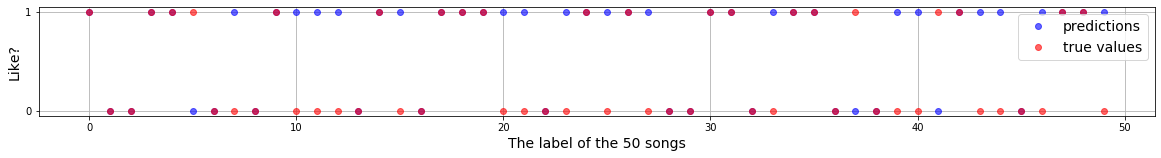

In [81]:
#Plot to compare the difference between the predicitons and the true values
plt.figure(figsize=(20,2))
plt.plot(resultf, 'bo', alpha = 0.6)
plt.plot(Ytest, 'ro', alpha = 0.6)
plt.legend(['predictions', 'true values'], fontsize = 14)
plt.grid('on')
plt.xlabel('The label of the 50 songs',fontsize=14)
plt.ylabel('Like?',fontsize=14)
plt.yticks([0,1])
plt.show()

Confusion matrix
[[13 17]
 [ 3 17]]


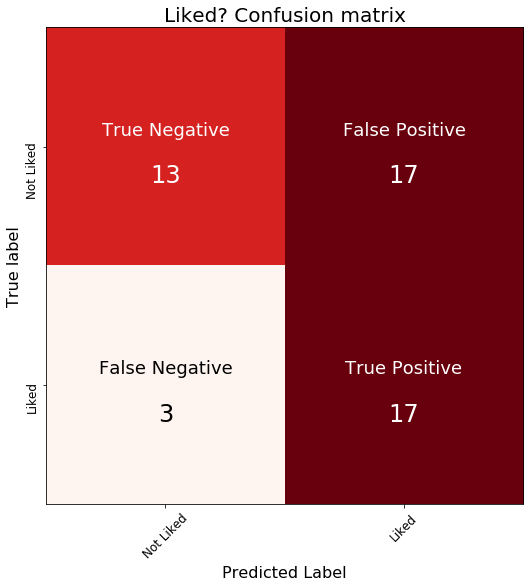

In [82]:
cm = confusion_matrix(Ytest, resultf)
plot_confusion_matrix(cm)